In [74]:
import networkx as nx
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random as rnd
rnd.seed()
import copy
from networkx.algorithms.community import girvan_newman
# import community as community_louvain
import community.community_louvain as community_louvain
import pickle

In [85]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

#     colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc', '#be254a', '#dc484c', '#ef6645', '#f88c51', '#fdb365', '#fed27f', '#feeb9d', '#fffebe', '#f0f9a7', '#d8ef9b', '#b3e0a2', '#89d0a4', '#60bba8', '#3f97b7', '#4273b3']

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 500
    ewidth = 2
    flabel = True

    if G.order() > 50:
        nsize  = 10
        ewidth = .01
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=ewidth,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r

    ##### do not modify above here #####
    ### YOUR CODE
    
    ##### do not modify below here #####
    
    for e in list(G.edges()):
        #etract node and its groups:
        # u, v = e 
        # r = z[u]
        # s = z[v]
        # print(e)
        r = z[int(e[0])]
        # print(r)
        s = z[int(e[1])]
        # print(s)
        #add values to structures:
        wrs[r, s] = wrs[r,s] + 1
        wrs[s, r] = wrs[s,r] + 1
        
    kpr = np.sum(wrs, axis=1) #row sum
            
    return wrs, kpr

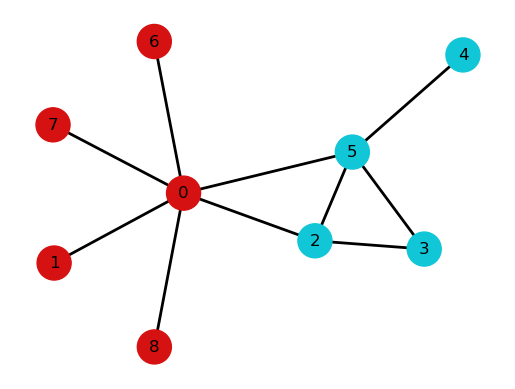

In [3]:
# Example demonstrating drawGz function

G = nx.Graph([(0,1),(0,2),(0,5),(0,6),(0,7),(0,8),(2,3),(2,5),(4,5),(3,5)]) # a simple graph G

# partition G into 2 groups (z as a dictionary)
z = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0}

drawGz(G,z)

In [76]:
#clusting functions from lab 6:

def girvan_newman_clusters(G, c=None):
    communities_generator = girvan_newman(G)

    if c is None:
        # If no specific number of clusters is provided, use the first level of communities
        communities = next(communities_generator)
    else:
        # Iterate through the dendrogram until the desired number of clusters is reached
        for communities in communities_generator:
            if len(communities) >= c:
                break

    # Create a dictionary with nodes as keys and their corresponding communities as values
    z = {}
    for community_index, community in enumerate(communities):
        for node in community:
            z[node] = community_index

    return z

#not used yet
def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION

def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####
    
    #calc rand group # [0-c-1]for each node:
    z = {i: int(rnd.randint(0,c-1)) for i in range(n)}

    ##### do not modify below here #####

    return z

##### do not modify below here #####
##    run this code once you've written the run_OnePhase() function

# Example illustrating grivan_newman clustering algorithm:

# c  = 3                   # c, number of groups
# # z0 = random_z(G.nodes(), c)
# zstar  = graph_clusters(G, c)
# # drawGz(G,z0)
# drawGz(G,zstar)
c = 2
# G = nx.karate_club_graph()
z = girvan_newman_clusters(G, c)
drawGz(G,z)
##### do not modify above here #####

KeyboardInterrupt: 

In [5]:
def get_c(graph):
    """
    Estimate the optimal number of clusters for a NetworkX graph using the Louvain method.

    :param graph: A NetworkX graph.
    :return: The estimated number of clusters.
    """
    partition = community_louvain.best_partition(graph)
    c = len(set(partition.values()))
    return c

def count_cluster_neighbors(G, z, n):
    # Initialize a dictionary to store the count of neighbors in each cluster
    cluster_counts = defaultdict(int)

    # Iterate through the neighbors of the given node
    for neighbor in G.neighbors(n):
        cluster_counts[z[neighbor]] += 1

    return dict(cluster_counts)
from collections import defaultdict

def custom_formula(G, z, n):
    #using this formula to find the bridge nodes, from the graph G, most formulas/algorithms 
    #only find edges, and if a node appear in multiple edges this does not get accounted for being significant, this algorithm does.
    # it is calculated by taking the 
    # Initialize a dictionary to store the count of neighbors in each cluster
    cluster_counts = defaultdict(int)

    # Iterate through the neighbors of the given node
    for neighbor in G.neighbors(n):
        cluster_counts[z[neighbor]] += 1

    # Calculate the sum of the number of neighbors not in the node's own cluster
    own_cluster = z[n]
    sum_other_clusters = sum(count for cluster, count in cluster_counts.items() if cluster != own_cluster)

    # Calculate the total number of clusters not within the node's own cluster
    total_other_clusters = len(set(z.values()) - {own_cluster})

    # Calculate the number of neighbor nodes within the node's own cluster
    neighbors_in_own_cluster = cluster_counts[own_cluster]

    # Compute the desired formula value
    if neighbors_in_own_cluster != 0:
        result = (sum_other_clusters * total_other_clusters) / neighbors_in_own_cluster
    else:
        result = 0
        
    return result

def find_bridges(G,z,flag=1):
    #returns list of all significant bridges in G in order of most connections to other clusters
    #returns string if no bridges found
    #flag = 1, is just the list of nodes, without their score vale, flag=0, there is score value
    if not nx.has_bridges(G): return 'No Bridges Found'
    
    send = []
    for node in list(G.nodes()):
        send.append((node, custom_formula(G,z,node)))
        
    sorted_nodes = [(node, value) for node, value in sorted(send, key=lambda x: x[1]) if value != 0]
    if flag: sorted_nodes = [node for node, value in sorted(sorted_nodes, key=lambda x: x[1])]
        
    return sorted_nodes

# sort nodes of G according to degree
def get_degree_list(G):
    # Get the degree for each node in the graph
    degree_dict = dict(G.degree())

    # Sort nodes in asceding order by their degree, can use pop() function for later use
    sorted_nodes = sorted(degree_dict.keys(), key=lambda x: degree_dict[x])

    return sorted_nodes

In [6]:
# Example illustrating 

# bridges_list = [33, 3, 31, 0, 8, 1, 7, 30, 19, 13, 2]
# degree_list = [11, 9, 12, 14, 15, 16, 17, 18, 20, 21, 22, 26, 4, 10, 19, 24, 25, 28, 5, 6, 7, 27, 29, 30, 8, 13, 23, 3, 31, 1, 2, 32, 0, 33]

# result = [x for x in degree_list if x not in bridges_list]

# print(np.array(list(G.neighbors(9))))

In [ ]:
#This section will be for the creation and running of the SIR model:
def run_SIR(G, vaccinated, s,beta,gamma,flag=0):
    # Basic SIR simulation
    # s = number of randomly chosen infected at the start
    # flag 0 = hide some output; flag 1 = show all outputs
    # beta  probability of {S-I} -> {I-I}
    # gamma  probability of {I}   -> {R}
    # filter/vaccinated represents vaccinated people (bridges or high degree)
    
    n  = G.order()
    
    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t
    
    myNodes = list(G.nodes())
    filtered_nodes = [node for node in myNodes if node not in vaccinated]
    
    # #activate infected 'i' and susceptible 's' nodes in dict 
    infected_nodes = np.random.choice(filtered_nodes, s,replace=False)
    xt = {node: ('R' if node in vaccinated else 'I' if node in infected_nodes else 'S')for node in range(len(G.nodes))}
    # xt = {i: 'I' if i in infected_nodes else 'S' for i in range(len(G.nodes))}    

    t = 0

    if flag:
        print(xt)
        print(f'time step {t}')
        drawGz(G,xt)
        
    t += 1
    Sc,Ic,Rc = n-1,1,len(vaccinated) # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    while any(xi == 'I' for xi in xt.values()) or any(xi == 'I' for xi in xu.values()):
        xu = copy.deepcopy(xt) # nodes states for next time step (synchronous updates)
        
        # do S -> I transitions
        for e in G.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if xt[i]=='I' and xt[j]=='S' and xu[j]!='I':
                if rnd.random() < beta:
                    xu[j] = 'I'       # i infects j for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if xt[i]=='S' and xt[j]=='I' and xu[i]!='I':
                if rnd.random() < beta:
                    xu[i] = 'I'       # j infects i for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R transitions
        for i in G.nodes():
            if xt[i] == 'I' and rnd.random() < gamma:
                xu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        xt = copy.deepcopy(xu)
        t  = t+1
        
        if flag:
            print(xt)
            print(f'time step {t}')
            drawGz(G,xt)
            
        # append these counts to the time series
        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) 
    
    # Calculate the information we are interested in from this simulation
    peak_infection = max(It)
    total_infected = Rt[-1]
    
    # Return only the information we are interested in
    return peak_infection, total_infected

#--TODO--#
# 1) multiple iterations
# 2) graphing Data
# 3) clustering
# 4) (mabye) modify the SIR model to vaccinate people over time
#--------#

# Function that runs an SIR simulation 'num_trials' times on 'G' with initially 'vaccinated' people
def SIR_trials(G, vaccinated, num_trials, s, beta, gamma):
    # Metrics we are interested in
    peak_infections = []
    total_infections = []
    
    for i in range(num_trials):
        # Run simulation 
        peak, total = run_SIR(G, vaccinated, s,beta,gamma,flag=0)
        
        peak_infections.append(peak)
        total_infections.append(total)
    
    # return metrics we are interested in as arrays of length = num_trials
    return peak_infections, total_infections

In [ ]:
# Code Cell to convert facebook100 .mat data files into usable networkx graphs

# Code based on https://github.com/timpostuvan/link-prediction-facebook100/blob/master/all-data/facebook100_parser.py

def get_attribute_partition(matlab_object, attribute):
    attribute_rows = matlab_object["local_info"]
    
    try:
        index = attribute_dict[attribute]
    except KeyError:
        raise KeyError("Given attribute " + attribute + " is not a valid choice.\nValid choices include\n" + str(attribute_dict.keys()))

    current_id = 0
    values = dict()
    for row in attribute_rows:
        if not(len(row) == 7):
            raise ValueError("Row " + str(current_id) + " has " + str(len(row)) + " rather than the expected 7 rows!")
       
        val = row[index]
        values[current_id] = int(val)
        current_id += 1

    return values

node_attributes = ["student_fac", "gender", "major_index", "second_major", "dorm", "year", "high_school"]

attribute_dict = {
    "student_fac" : 0,
    "gender" : 1,
    "major_index" : 2,
    "second_major" : 3,
    "dorm" : 4,
    "year" : 5,
    "high_school" : 6,
    }

# Function that, given a filename from the facebook100 dataset, returns a networkx graph
def graph_from_filename(filename):
    # load file
    matlab_object = sio.loadmat(filename)
    # generate sparse array using scipy function
    scipy_sparse_graph = matlab_object["A"]
    # convert to 
    G = nx.from_scipy_sparse_array(scipy_sparse_graph)

    # assign attributes
    for attribute in attribute_dict:
                values = get_attribute_partition(matlab_object, attribute)
                for node in values:
                        G.nodes[node][attribute] = values[node]

    # Return desired network
    return G

# Does community detection on file and saves partition to file
def save_communities(filename):
    G = graph_from_filename(filename)
    c = get_c(G)
    print("c=", c, "for file", filename)
    z = girvan_newman_clusters(G, c)
    dict_filename = "./partitions/" + filename[14:-4] + ".pkl"
    with open(dict_filename, 'wb') as fp:
        pickle.dump(z, fp)
        print("saved", dict_filename)
        
# Get dictionary from file
def load_communities(dict_filename):
    with open(dict_filename, 'rb') as fp:
        z = pickle.load(fp)
        return z

In [ ]:
# Function that vaccinates people at random
def strategy_random(G, num_vaccinated, num_trials, s = 1, beta=.3, gamma=.3):
    # pick num_vaccinated people at random
    random_nodes = np.random.choice(G.nodes(), size=num_vaccinated, replace=False)

    # run simulation num_trials times
    peak_infections, total_infections = SIR_trials(G, random_nodes, num_trials, s,beta,gamma)
    
    return peak_infections, total_infections
        
# Function that finds bridges and runs SIR num_trials times
def strategy_bridge(G, dict_filename, num_vaccinated, num_trials, s = 1, beta=.3, gamma=.3):
    # need to open file for partition z
    z = load_communities(dict_filename)
    bridges_list = find_bridges(G,z)
    # get num_vaccinated bridges
    bridges_list = bridges_list[-num_vaccinated:]

    # run simulation num_trials times
    peak_infections, total_infections = SIR_trials(G, bridges_list, num_trials, s,beta,gamma)
    
    return peak_infections, total_infections

# Function that takes num_vaccinated number of highest degree nodes and runs SIR with those vaccinated
def strategy_highdegree(G, num_vaccinated, num_trials, s = 1, beta=.3, gamma=.3):
    degree_list = get_degree_list(G)
    # get num_vaccinated high value nodes
    degree_list = degree_list[-num_vaccinated:]
    
    # run simulation num_trials times
    peak_infections, total_infections = SIR_trials(G, degree_list, num_trials, s,beta,gamma)
    
    return peak_infections, total_infections

karate club c: 4


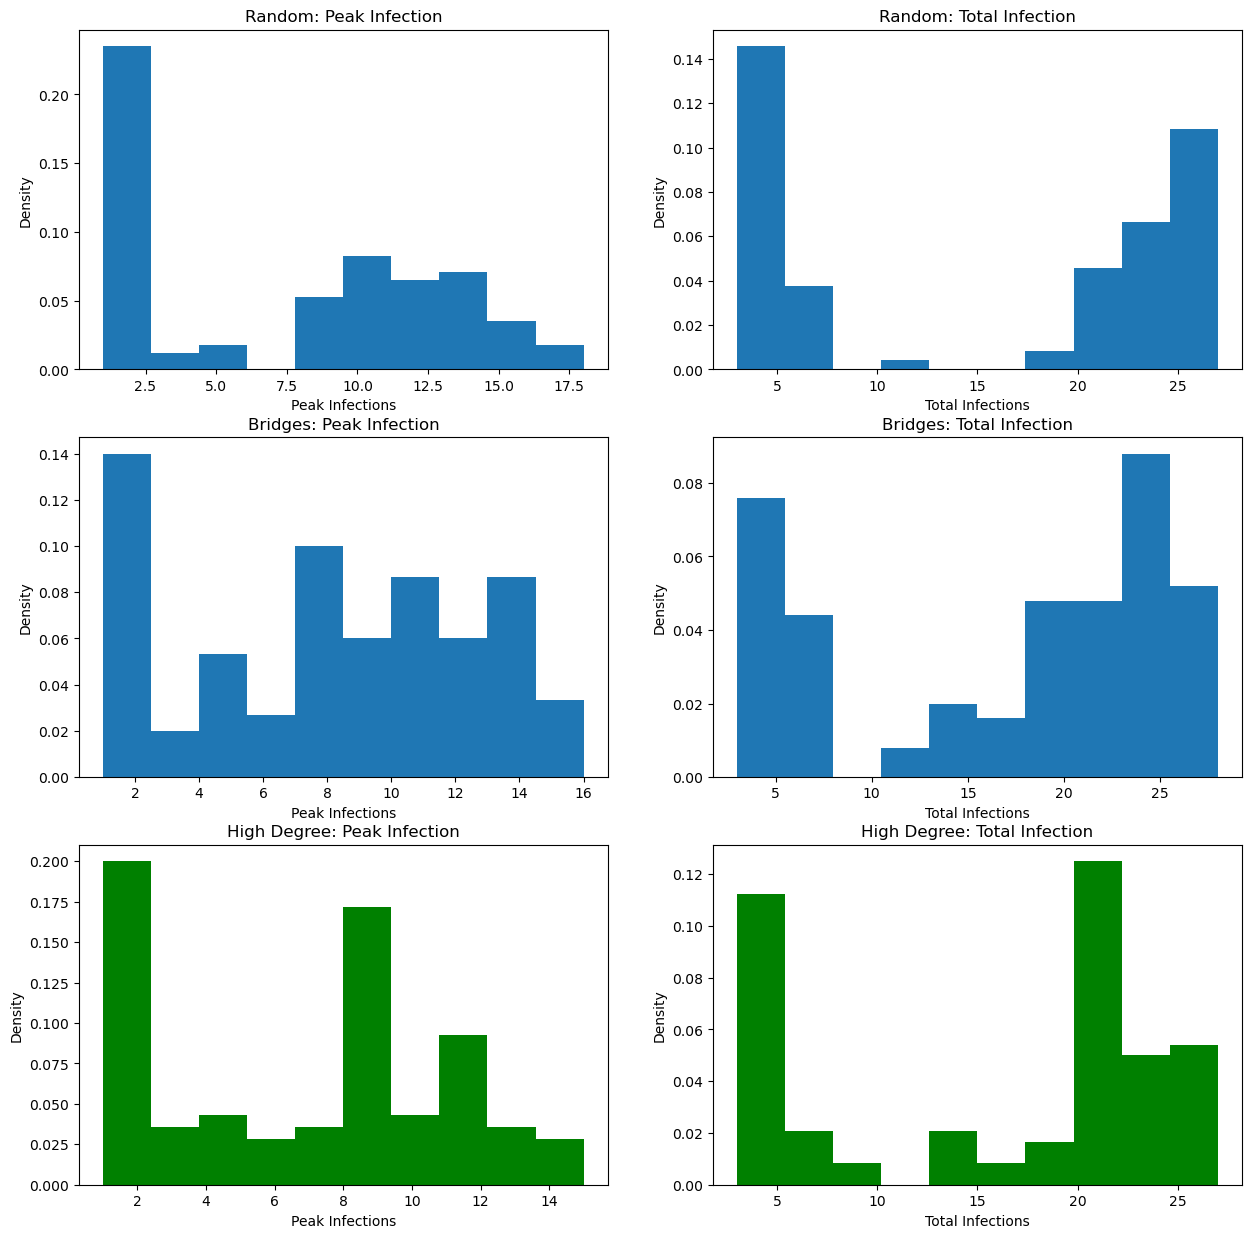

In [10]:
# # Example of running SIR and plotting using a small network (zach's karate club)
# G = nx.karate_club_graph()

# # Data 
# num_vaccinated = 2
# num_trials = 100
# s = 1
# beta = .3
# gamma = .3

# # Run SIR simulation according to each strategy
# random_peaks, random_totals = strategy_random(G, num_vaccinated, num_trials, s, beta, gamma)
# c = get_c(G)
# print("karate club c:", c)
# bridge_peaks, bridge_totals = strategy_bridge(G, c, num_vaccinated, num_trials, s, beta, gamma)
# highdegree_peaks, highdegree_totals = strategy_highdegree(G, num_vaccinated, num_trials, s, beta, gamma)

# # Graph results by vaccination strategy(histograms of peak/total infections)
# fig, axes = plt.subplots(3, 2, figsize=(15, 15))
# axes[0][0].hist(random_peaks, density=True)
# axes[0][0].set_title("Random: Peak Infection")
# axes[0][0].set_xlabel("Peak Infections")
# axes[0][0].set_ylabel("Density")
# axes[0][1].hist(random_totals, density=True)
# axes[0][1].set_title("Random: Total Infection")
# axes[0][1].set_xlabel("Total Infections")
# axes[0][1].set_ylabel("Density")

# axes[1][0].hist(bridge_peaks, density=True)
# axes[1][0].set_title("Bridges: Peak Infection")
# axes[1][0].set_xlabel("Peak Infections")
# axes[1][0].set_ylabel("Density")
# axes[1][1].hist(bridge_totals, density=True)
# axes[1][1].set_title("Bridges: Total Infection")
# axes[1][1].set_xlabel("Total Infections")
# axes[1][1].set_ylabel("Density")

# axes[2][0].hist(highdegree_peaks, density=True, color="g")
# axes[2][0].set_title("High Degree: Peak Infection")
# axes[2][0].set_xlabel("Peak Infections")
# axes[2][0].set_ylabel("Density")
# axes[2][1].hist(highdegree_totals, density=True, color="g")
# axes[2][1].set_title("High Degree: Total Infection")
# axes[2][1].set_xlabel("Total Infections")
# axes[2][1].set_ylabel("Density");

In [11]:
# Takes ~46 hours to partition network of n=6386, m=217662

# filename = "./facebook100/American75.mat"
# save_communities(filename)

c= 20 for file ./facebook100/American75.mat
saved ./partitions/American75.pkl


In [87]:
def plot_CCDF(kis):
    # from PS5
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

def compute_MGD(G):
    # from PS3
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)

    dij = dict(nx.all_pairs_shortest_path_length(G)) # APSP on G, store as a dictionary (tricky :)

    ells = []                            # list of non-zero and non-infinite lengths
    for node in dij:                     # loop over all the nodes
        temp = list(dij[node].values())  #   get the list of distances
        for length in temp:              #     for each of those distances
            if length>0:                 #     ignore if =0
                ells.append(length)      #     otherwise, add it to ells
                
    ellmean = np.mean(ells)              # MGD = numpy mean of ells list
    return ellmean

In [90]:

# Converts a filename of the facebook100 dataset to a usable networkx graph
filename = "./facebook100/American75.mat"
G = graph_from_filename(filename)
num_nodes = G.number_of_nodes()

print("n:", num_nodes)
print("m:", G.number_of_edges())
print("kmean:", sum([d for (node, d) in G.degree()]) / num_nodes)
print("C:", nx.transitivity(G))
print("ellmean:", compute_MGD(G))
plot_CCDF(G.degree())

n: 6386
m: 217662
kmean: 68.16849357970561
C: 0.16354459255048673


KeyboardInterrupt: 

In [ ]:
# Data 
num_vaccinated = int(num_nodes/5) # maybe change this to percent vaccinated, for consistency across networks
num_trials = 100
s = 1
beta = .3
gamma = .3

# Run SIR simulation according to each strategy
random_peaks, random_totals = strategy_random(G, num_vaccinated, num_trials, s, beta, gamma)

dict_filename = "./partitions/" + filename[14:-4] + ".pkl"
bridge_peaks, bridge_totals = strategy_bridge(G, dict_filename, num_vaccinated, num_trials, s, beta, gamma)

highdegree_peaks, highdegree_totals = strategy_highdegree(G, num_vaccinated, num_trials, s, beta, gamma)


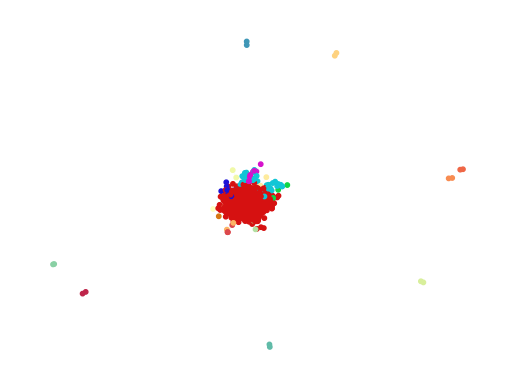

In [86]:
z = load_communities(dict_filename)
drawGz(G,z)

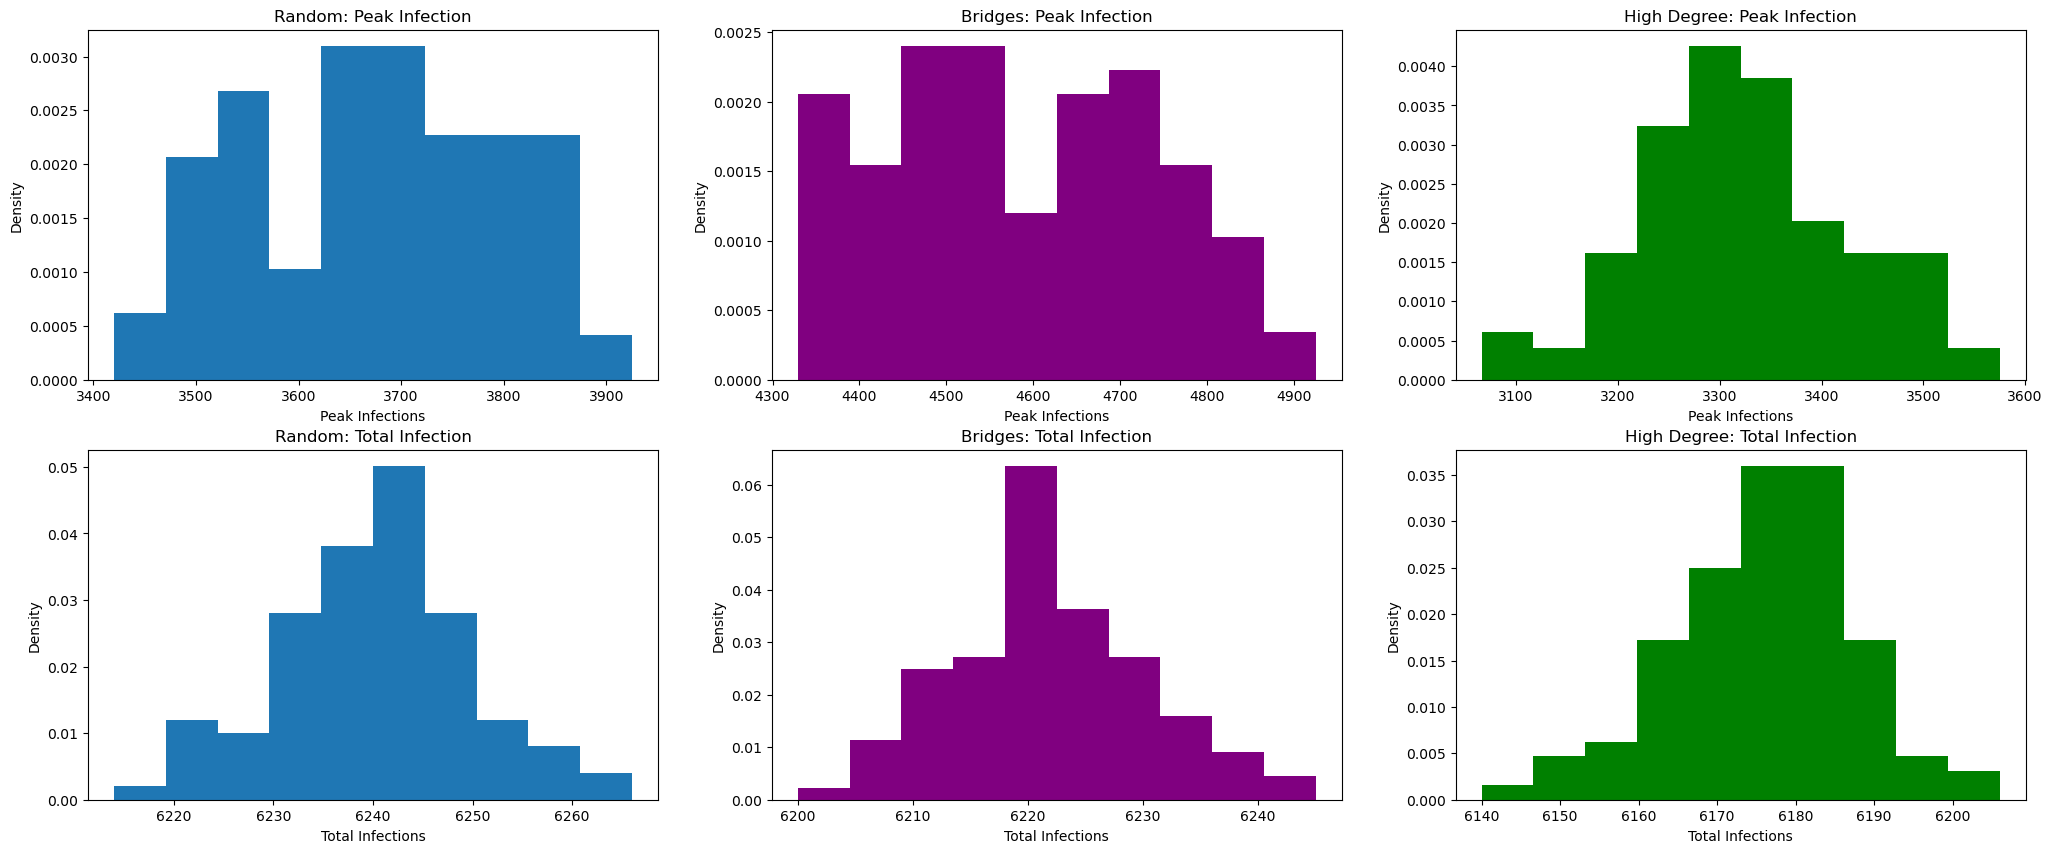

In [70]:
# Remove trials whose epidemic didn't start
random_peaks_trimmed = [temp for temp in random_peaks if temp > 2000]
random_totals_trimmed = [temp for temp in random_totals if temp > 2000]
bridge_peaks_trimmed = [temp for temp in bridge_peaks if temp > 2000]
bridge_totals_trimmed = [temp for temp in bridge_totals if temp > 2000]
highdegree_peaks_trimmed = [temp for temp in highdegree_peaks if temp > 2000]
highdegree_totals_trimmed = [temp for temp in highdegree_totals if temp > 2000]

# Graph results by vaccination strategy(histograms of peak/total infections)
fig, axes = plt.subplots(2, 3, figsize=(25, 10))
axes[0][0].hist(random_peaks_trimmed, density=True)
axes[0][0].set_title("Random: Peak Infection")
axes[0][0].set_xlabel("Peak Infections")
axes[0][0].set_ylabel("Density")

axes[0][1].hist(bridge_peaks_trimmed, density=True, color="purple")
axes[0][1].set_title("Bridges: Peak Infection")
axes[0][1].set_xlabel("Peak Infections")
axes[0][1].set_ylabel("Density")

axes[0][2].hist(highdegree_peaks_trimmed, density=True, color="g")
axes[0][2].set_title("High Degree: Peak Infection")
axes[0][2].set_xlabel("Peak Infections")
axes[0][2].set_ylabel("Density")

axes[1][0].hist(random_totals_trimmed, density=True)
axes[1][0].set_title("Random: Total Infection")
axes[1][0].set_xlabel("Total Infections")
axes[1][0].set_ylabel("Density")


axes[1][1].hist(bridge_totals_trimmed, density=True, color="purple")
axes[1][1].set_title("Bridges: Total Infection")
axes[1][1].set_xlabel("Total Infections")
axes[1][1].set_ylabel("Density")


axes[1][2].hist(highdegree_totals_trimmed, density=True, color="g")
axes[1][2].set_title("High Degree: Total Infection")
axes[1][2].set_xlabel("Total Infections")
axes[1][2].set_ylabel("Density");

In [72]:
print("Average peak infections:")
print(" Random", int(np.mean(random_peaks_trimmed)))
print(" Bridge", int(np.mean(bridge_peaks_trimmed)))
print(" High deg.", int(np.mean(highdegree_peaks_trimmed)))

print("\n Average total infections:")
print(" Random", int(np.mean(random_totals_trimmed)))
print(" Bridge", int(np.mean(bridge_totals_trimmed)))
print(" High deg.", int(np.mean(highdegree_totals_trimmed)))

Average peak infections:
 Random 3674
 Bridge 4588
 High deg. 3325

 Average total infections:
 Random 6239
 Bridge 6221
 High deg. 6176


In [97]:
# runs all strategies w/ percent_vaccinated vaccinated and graph results
def run_sims(filename, percent_vaccinated, num_trials=100, s=1, beta=.3, gamma=.3):
    G = graph_from_filename(filename)

    num_vaccinated = int(G.number_of_nodes()*percent_vaccinated)

    # Run SIR simulation according to each strategy
    random_peaks, random_totals = strategy_random(G, num_vaccinated, num_trials, s, beta, gamma)

    dict_filename = "./partitions/" + filename[14:-4] + ".pkl"
    bridge_peaks, bridge_totals = strategy_bridge(G, dict_filename, num_vaccinated, num_trials, s, beta, gamma)

    highdegree_peaks, highdegree_totals = strategy_highdegree(G, num_vaccinated, num_trials, s, beta, gamma)
    
    return [random_peaks, random_totals, bridge_peaks, bridge_totals, highdegree_peaks, highdegree_totals]

def plot_results(results):
    random_peaks, random_totals, bridge_peaks, bridge_totals, highdegree_peaks, highdegree_totals = results
    
    # Remove trials whose epidemic didn't start
    random_peaks_trimmed = [temp for temp in random_peaks if temp > 10]
    random_totals_trimmed = [temp for temp in random_totals if temp > 100]
    bridge_peaks_trimmed = [temp for temp in bridge_peaks if temp > 10]
    bridge_totals_trimmed = [temp for temp in bridge_totals if temp > 100]
    highdegree_peaks_trimmed = [temp for temp in highdegree_peaks if temp > 10]
    highdegree_totals_trimmed = [temp for temp in highdegree_totals if temp > 100]

    # Graph results by vaccination strategy(histograms of peak/total infections)
    fig, axes = plt.subplots(2, 3, figsize=(25, 10))
    axes[0][0].hist(random_peaks_trimmed, density=True)
    axes[0][0].set_title("Random: Peak Infection")
    axes[0][0].set_xlabel("Peak Infections")
    axes[0][0].set_ylabel("Density")

    axes[0][1].hist(bridge_peaks_trimmed, density=True, color="purple")
    axes[0][1].set_title("Bridges: Peak Infection")
    axes[0][1].set_xlabel("Peak Infections")
    axes[0][1].set_ylabel("Density")

    axes[0][2].hist(highdegree_peaks_trimmed, density=True, color="g")
    axes[0][2].set_title("High Degree: Peak Infection")
    axes[0][2].set_xlabel("Peak Infections")
    axes[0][2].set_ylabel("Density")

    axes[1][0].hist(random_totals_trimmed, density=True)
    axes[1][0].set_title("Random: Total Infection")
    axes[1][0].set_xlabel("Total Infections")
    axes[1][0].set_ylabel("Density")


    axes[1][1].hist(bridge_totals_trimmed, density=True, color="purple")
    axes[1][1].set_title("Bridges: Total Infection")
    axes[1][1].set_xlabel("Total Infections")
    axes[1][1].set_ylabel("Density")


    axes[1][2].hist(highdegree_totals_trimmed, density=True, color="g")
    axes[1][2].set_title("High Degree: Total Infection")
    axes[1][2].set_xlabel("Total Infections")
    axes[1][2].set_ylabel("Density");
    
    print("Average peak infections:")
    print(" Random", int(np.mean(random_peaks_trimmed)))
    print(" Bridge", int(np.mean(bridge_peaks_trimmed)))
    print(" High deg.", int(np.mean(highdegree_peaks_trimmed)))

    print("\n Average total infections:")
    print(" Random", int(np.mean(random_totals_trimmed)))
    print(" Bridge", int(np.mean(bridge_totals_trimmed)))
    print(" High deg.", int(np.mean(highdegree_totals_trimmed)));

In [94]:
filename = "./facebook100/American75.mat"
results = run_sims(filename, .5)

Percent Vaccinated = 0.5
Average peak infections:
 Random 2168
 Bridge 4605
 High deg. 1255

 Average total infections:
 Random 6117
 Bridge 6098
 High deg. 5490


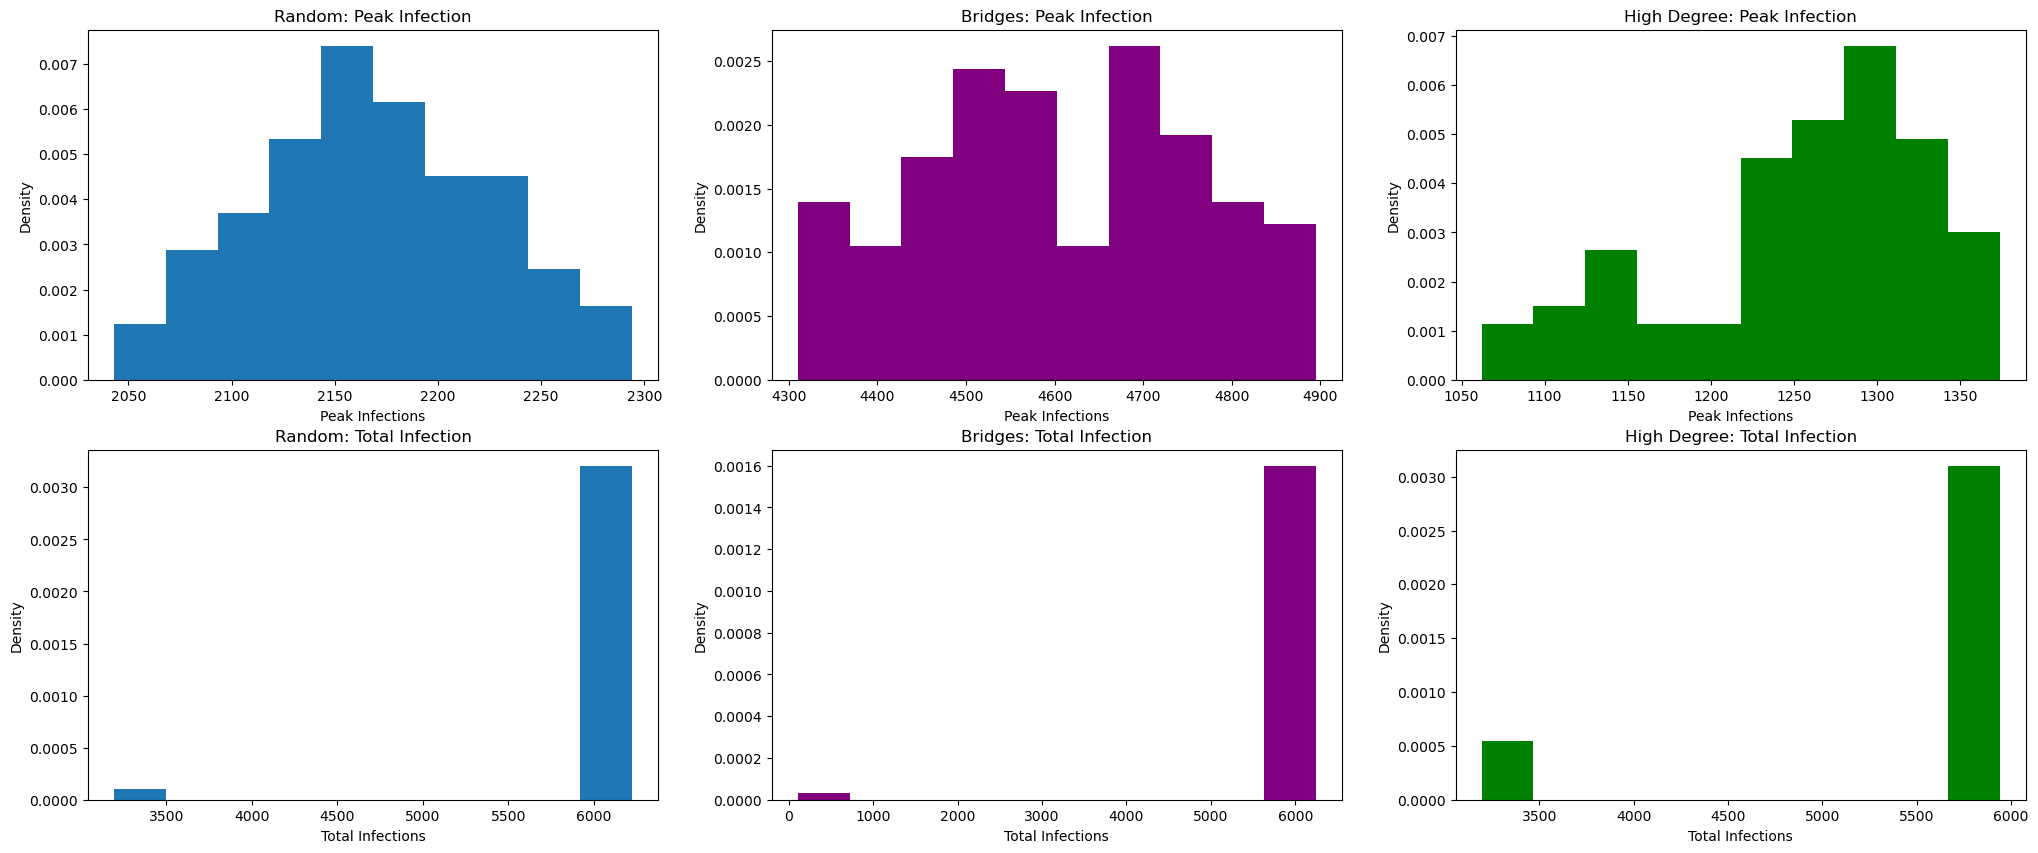

In [98]:
print("Percent Vaccinated = 0.5")
plot_results(results)

In [101]:
percent_vaccinated = [0.01, 0.1, 0.25, 0.5, 0.75]

results = []
for p in percent_vaccinated:
    results.append(run_sims(filename, p, num_trials=50))

Percent Vaccinated =  0.01
Average peak infections:
 Random 4614
 Bridge 4645
 High deg. 4563

 Average total infections:
 Random 6256
 Bridge 6223
 High deg. 6249
Percent Vaccinated =  0.1
Average peak infections:
 Random 4136
 Bridge 4599
 High deg. 3970

 Average total infections:
 Random 5905
 Bridge 5976
 High deg. 5990
Percent Vaccinated =  0.25
Average peak infections:
 Random 3371
 Bridge 4583
 High deg. 3038

 Average total infections:
 Random 6031
 Bridge 5975
 High deg. 6062
Percent Vaccinated =  0.5
Average peak infections:
 Random 2156
 Bridge 4599
 High deg. 1243

 Average total infections:
 Random 5900
 Bridge 6216
 High deg. 5194
Percent Vaccinated =  0.75
Average peak infections:
 Random 933
 Bridge 4592
 High deg. 14

 Average total infections:
 Random 6048
 Bridge 6098
 High deg. 4794


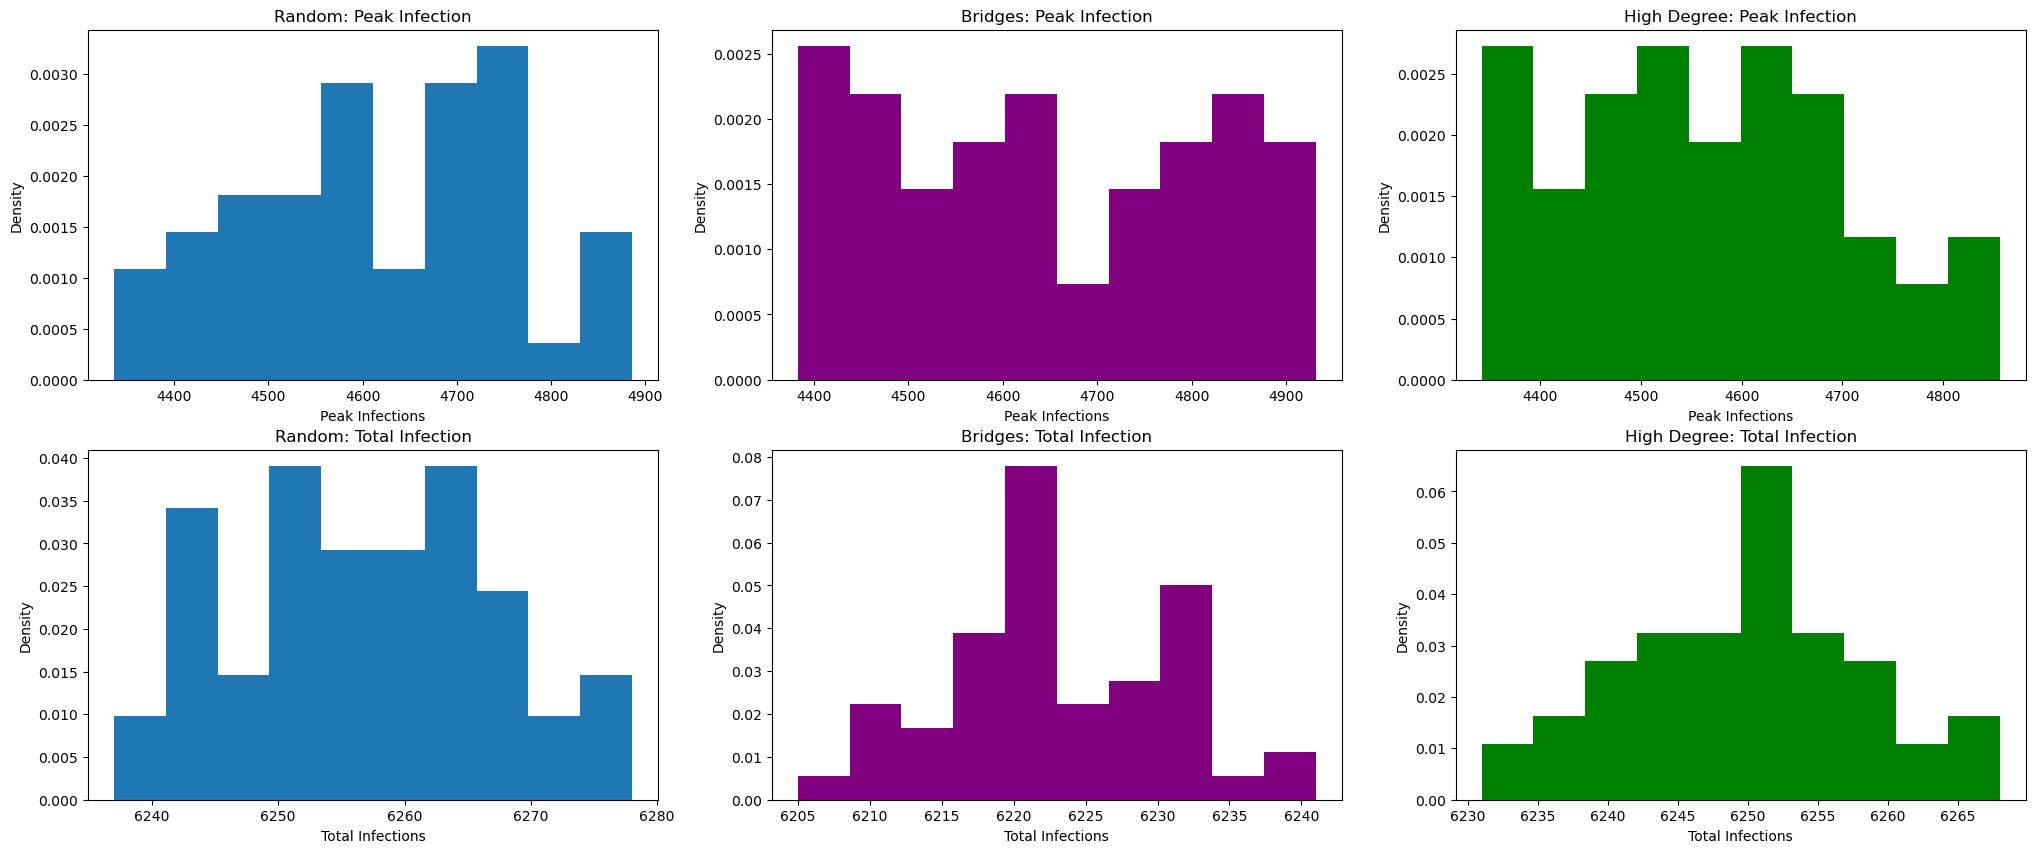

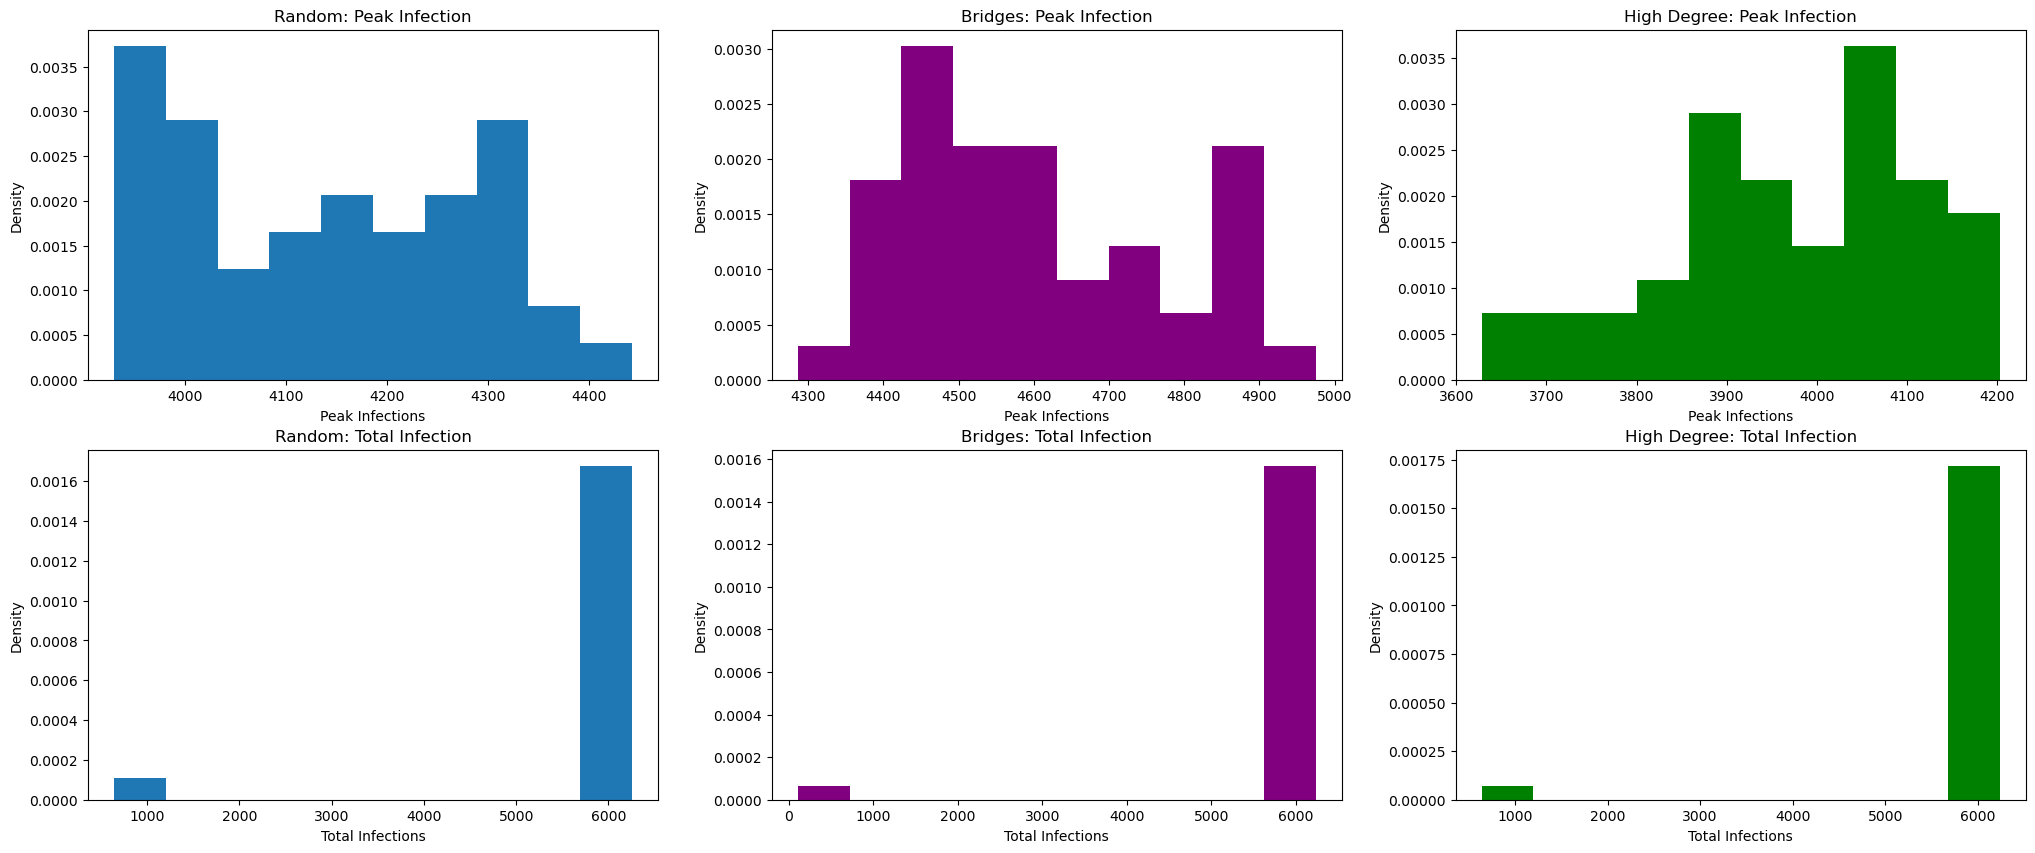

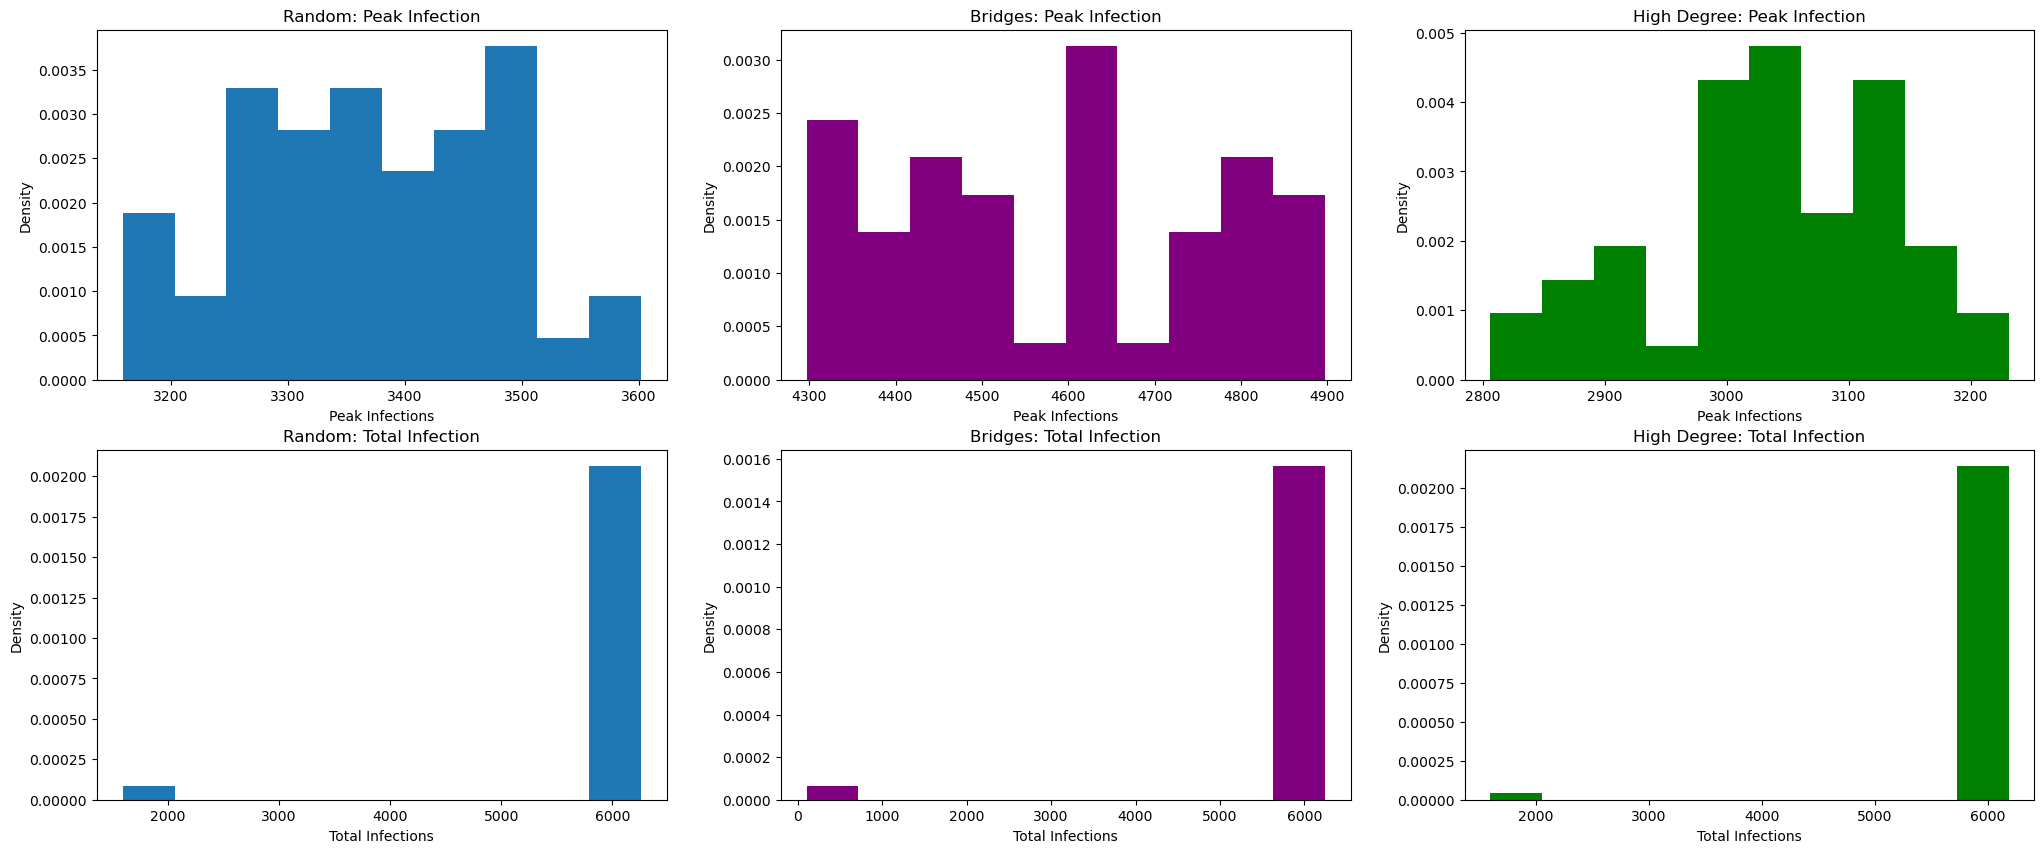

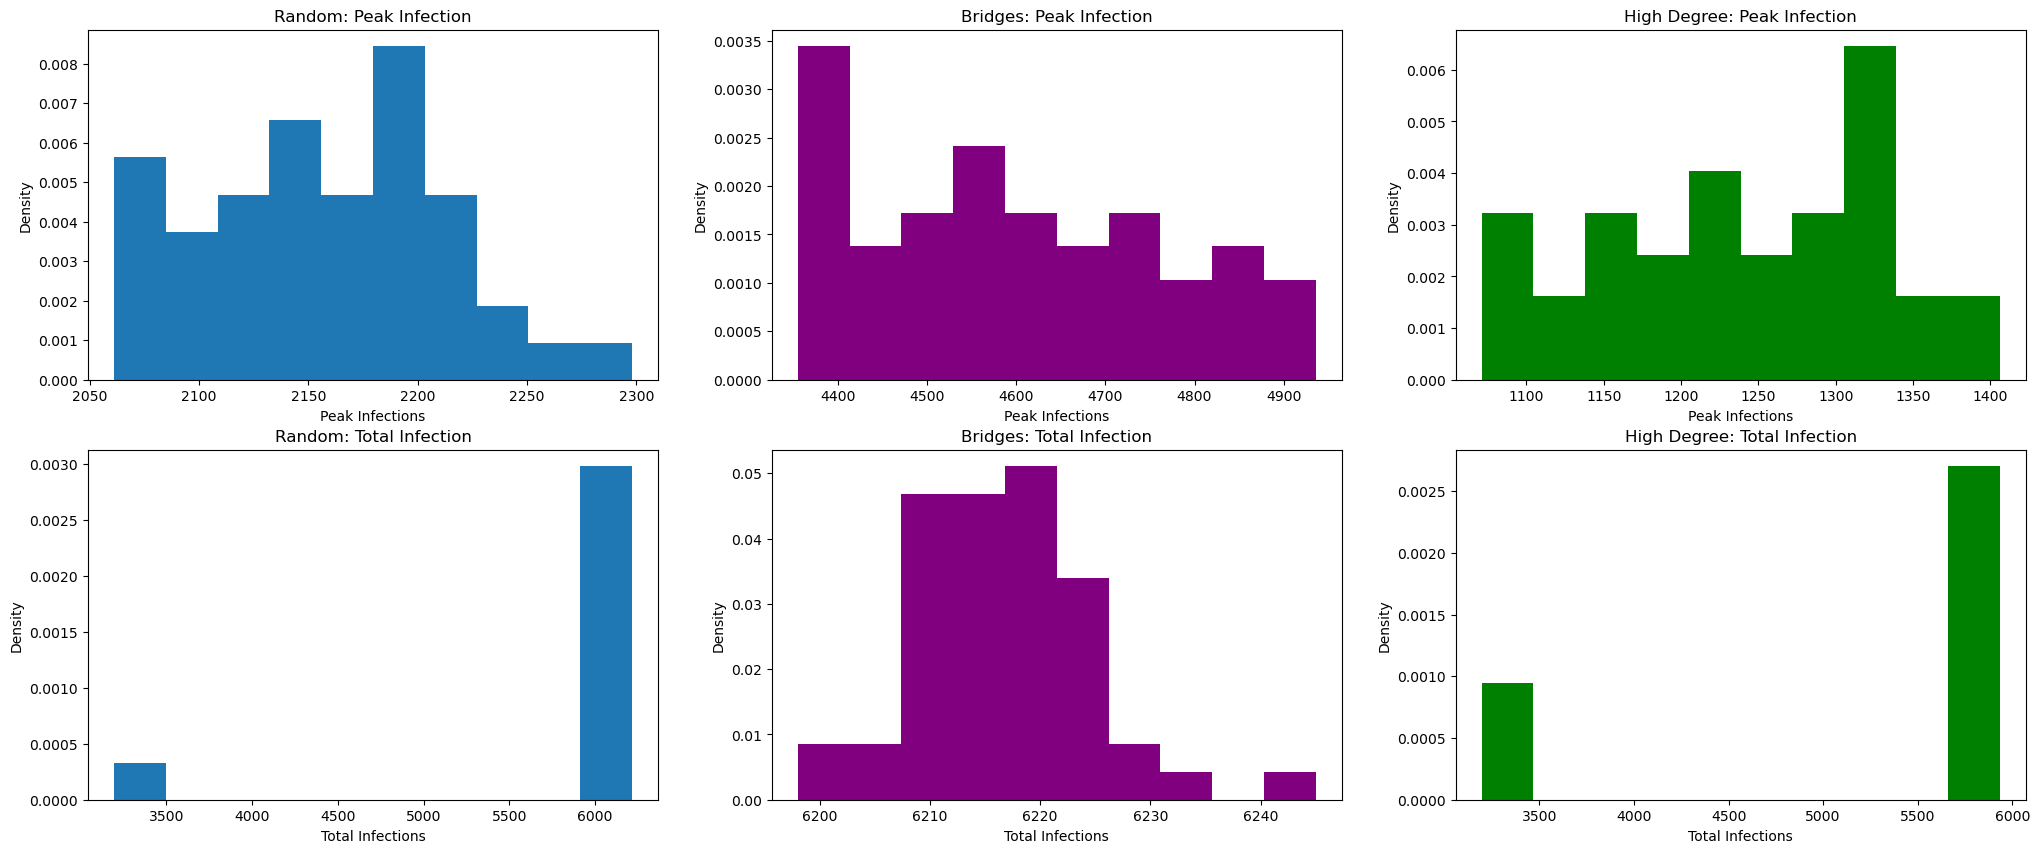

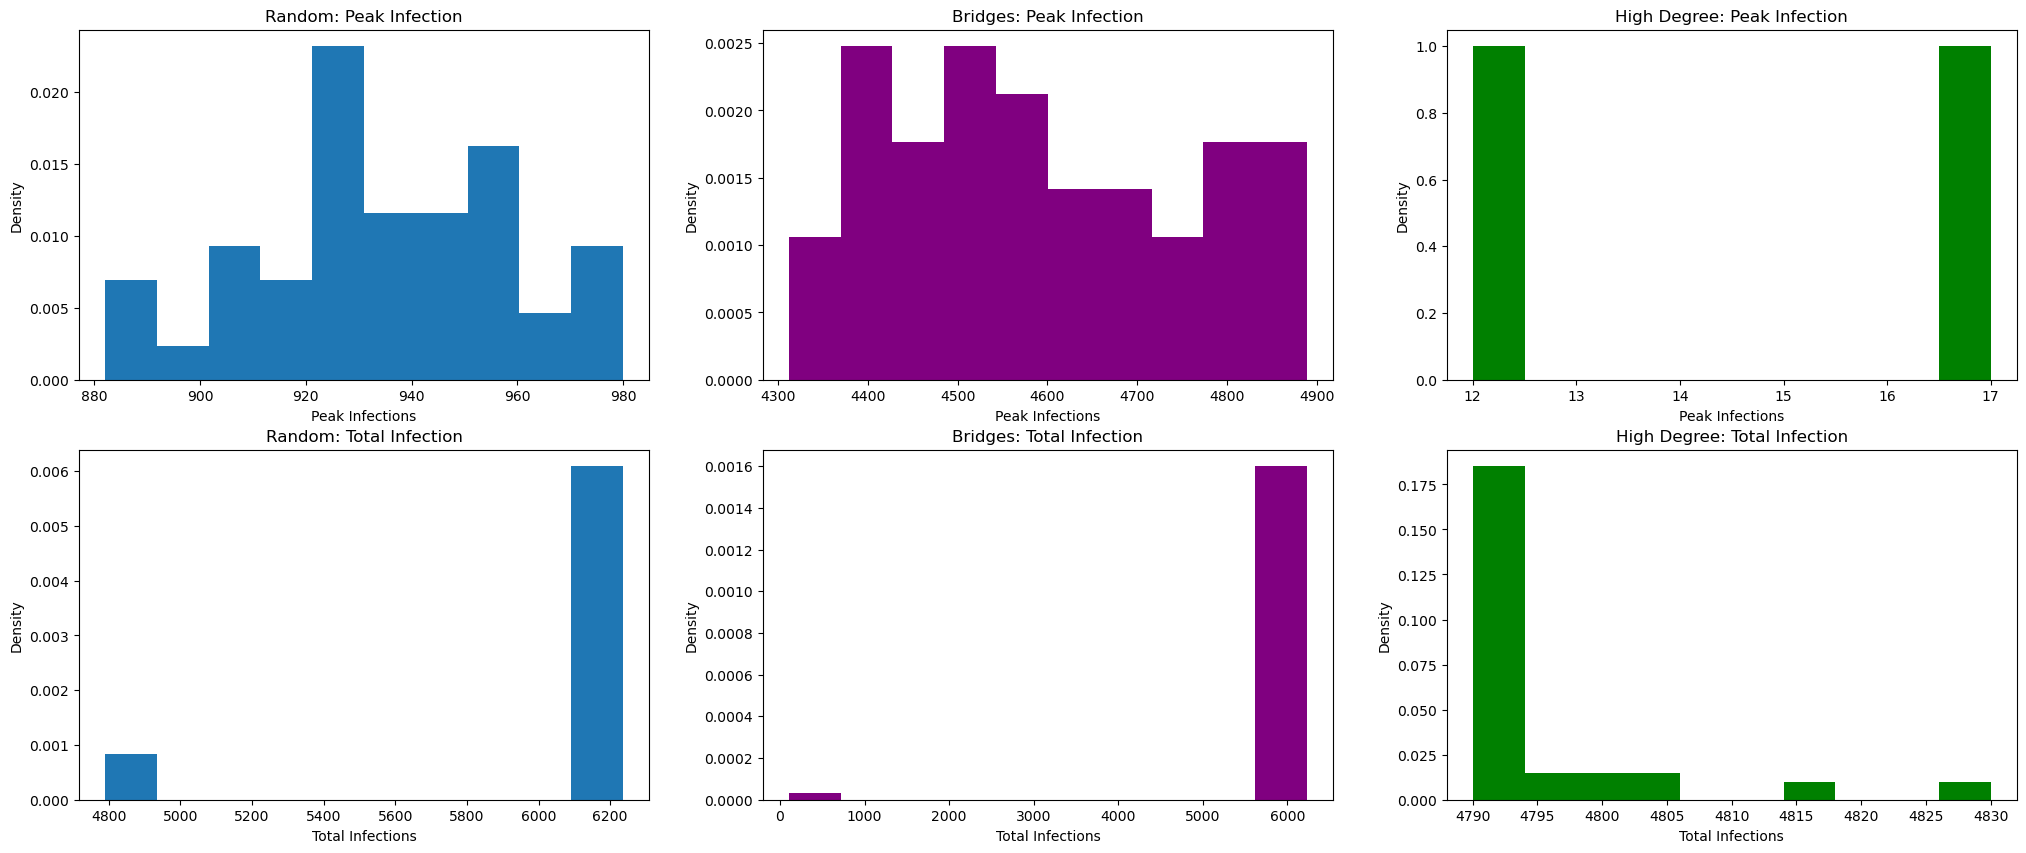

In [102]:
for i in range(len(percent_vaccinated)):
    print("Percent Vaccinated = ", percent_vaccinated[i])
    plot_results(results[i])